# [Xarray](https://docs.xarray.dev/en/stable/) interface for Madagascar

With this feature all the madagascar programs can be used in python script and be applied on [Xarray](https://docs.xarray.dev/en/stable/) DataArrays. This feature is the extenstion of [numpy interface](https://ahay.org/blog/?s=python+interface)

```mxarray``` is not installed by default if the host doesn't have Xarray. If you install Xarray after installing madagascar, rebuild the ```$PYTHONPATH``` by simply running ```scons $PYTHONPATH``` from ```$RSFSRC``` directory

In [ ]:
import numpy as np
import xarray as xr

import mxarray as mx
import m8r

import matplotlib.pyplot as plt
from scipy.signal import chirp

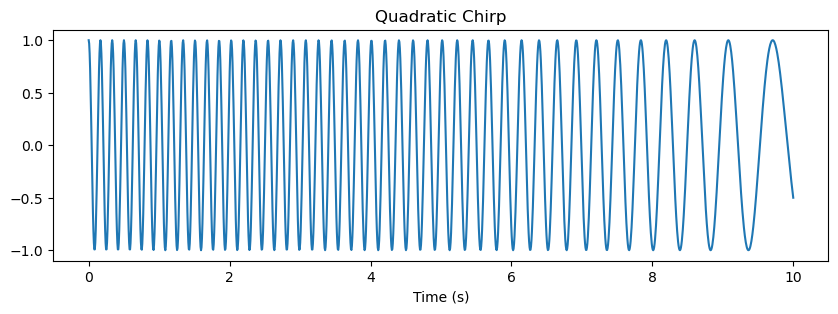

In [2]:
t = np.linspace(0, 10, 1500)
c = chirp(t, f0=6, f1=1, t1=10, method='quadratic')     # numpy array

plt.figure(figsize=(10, 3))
plt.plot(t, c)
plt.title('Quadratic Chirp')
plt.xlabel('Time (s)')
plt.show()


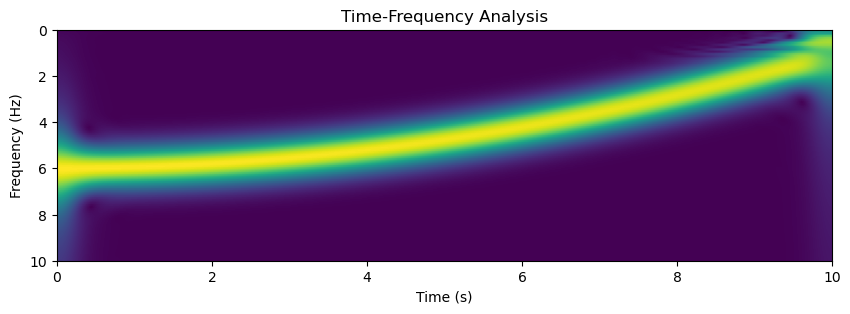

In [3]:
transform = m8r.put(o1=0,d1=t[1]).timefreq(rect=50,dw=0.1,nw=101)
tf = transform.apply(c)

plt.figure(figsize=(10, 3))
plt.imshow(tf,extent=[0,10,10,0],aspect='auto')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Time-Frequency Analysis')
plt.show()

In [4]:
print(f'Type of c: {type(c)}')
print(f'Type of tf: {type(tf)}')
print(f'Shape of tf: {tf.shape}')

Type of c: <class 'numpy.ndarray'>
Type of tf: <class 'numpy.ndarray'>
Shape of tf: (101, 1500)


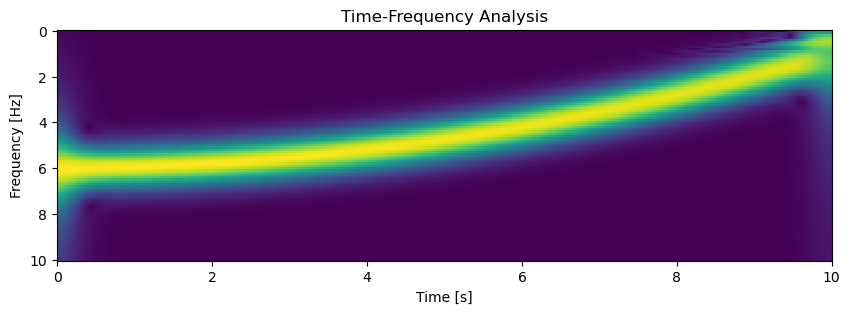

In [5]:
c_xr = xr.DataArray(                           # xarray DataArray
                c, 
                dims=["Time"], 
                coords={"Time": t}, 
                name="chirp_signal"
                )
c_xr.Time.attrs['units'] = 's'
c_xr.attrs['long_name'] = 'Amplitude'

transform = m8r.timefreq(rect=50,dw=0.1,nw=101)
tf_xr = transform.apply(c_xr)

assert tf_xr.dims[0] == 'Time' and tf_xr.dims[1] == 'Frequency'
assert tf_xr.Time.size == len(c_xr)
assert tf_xr.Frequency.size == 101

fig, ax = plt.subplots(figsize=(10, 3))
im = tf_xr.transpose().plot(
    ax=ax, 
    yincrease=False, 
    add_colorbar=False)
ax.set_title('Time-Frequency Analysis')
plt.show()

In [6]:
print(f'Type of c_xr: {type(c_xr)}')
print(f'Type of tf_xr: {type(tf_xr)}')
print(f'Shape of tf_xr: {tf_xr.shape}') # same as rsf order (n1, n2)

Type of c_xr: <class 'xarray.core.dataarray.DataArray'>
Type of tf_xr: <class 'xarray.core.dataarray.DataArray'>
Shape of tf_xr: (1500, 101)


## Simple convolution modeling with mxarray

In [7]:
xmax = 1.0   
zmax = 0.5  
nx = 1001   
nz = 501     

x = np.linspace(0, xmax, nx)
z = np.linspace(0, zmax, nz)

vp1, vp2, vp3, vp4 = 1.0, 1.5, 2.0, 3.0

# Interface 1 
freq1 = 2.5 * (2 * np.pi / xmax)
Z_int1 = 0.12 + 0.015 * np.cos(freq1 * x)

# Interface 2 
freq2 = 2.0 * (2 * np.pi / xmax)
Z_int2 = 0.25 - 0.05 * np.cos(freq2 * x)

# Interface 3 
depth_3 = 0.375

surfaces = xr.DataArray(
    np.column_stack([Z_int1, Z_int2, np.full_like(x, depth_3)]),
    dims = ("X", "Interface"),
    coords = {
        "X": x,
        "Interface": [1, 2, 3],
    },
)
surfaces.Interface.attrs['long_name'] = 'Interface Number'
surfaces.X.attrs['units'] = 'km'

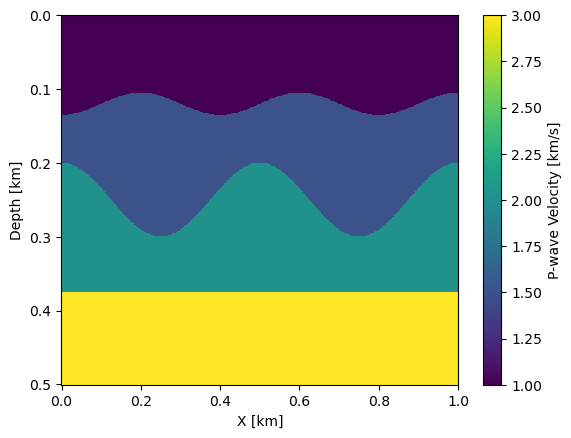

In [8]:
unif2 = m8r.unif2(d1=0.001, n1=501, v00=f'{vp1},{vp2},{vp3},{vp4}')
Vp = unif2.apply(surfaces)
Vp.attrs['long_name'] = 'P-wave Velocity'
Vp.attrs['units'] = 'km/s'
Vp.plot(yincrease=False)

In [9]:
print(f"Type of Vp: {type(Vp)}")
Vp = Vp.chunk("auto")  # Enable Dask array chunking for large datasets (this is done by default)

Type of Vp: <class 'xarray.core.dataarray.DataArray'>


In [10]:
Vp

<xarray.DataArray 'transpose-0eb427d9b432ac61f16a2a043891f698' (Depth: 501,
                                                                X: 1001)>
dask.array<transpose, shape=(501, 1001), dtype=float32, chunksize=(501, 1001), chunktype=numpy.ndarray>
Coordinates:
  * Depth    (Depth) float64 0.0 0.001 0.002 0.003 ... 0.497 0.498 0.499 0.5
  * X        (X) float64 0.0 0.001 0.002 0.003 0.004 ... 0.997 0.998 0.999 1.0
Attributes:
    long_name:  P-wave Velocity
    units:      km/s

### Reading and writing ```rsf``` files to and from ```xarray.DataArray```

In [11]:
mx.xarray_to_rsf(Vp, 'vp_model.rsf')
!file vp_model.rsf
!file `sfin vp_model.rsf | sed -n 's/.*in="\(.*\)".*/\1/p' `
Vp_read = mx.rsf_to_xarray('vp_model.rsf')
assert Vp_read.equals(Vp)

vp_model.rsf: ASCII text
/Users/ss226227/RSFDATA/vp_model.rsf@: data


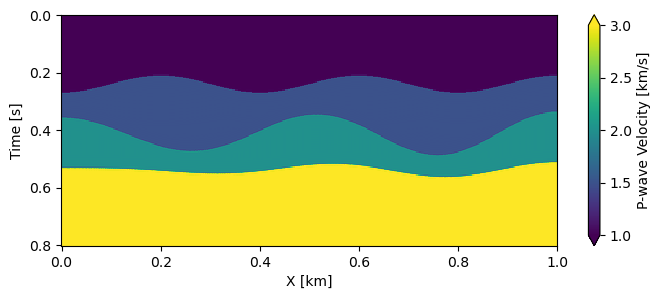

In [12]:
# depth2time
depth2time = m8r.depth2time(velocity=Vp, dt=.004, nt=201, t0=0.0)
Vp_time = depth2time.apply(Vp)

# rename depth coordinate to time
Vp_time = Vp_time.rename({'Depth': 'Time'})
Vp_time.Time.attrs = {'units': 's'}
Vp_time.plot(figsize=(8, 3), cmap='viridis', yincrease=False, vmin=1.0, vmax=3.0)

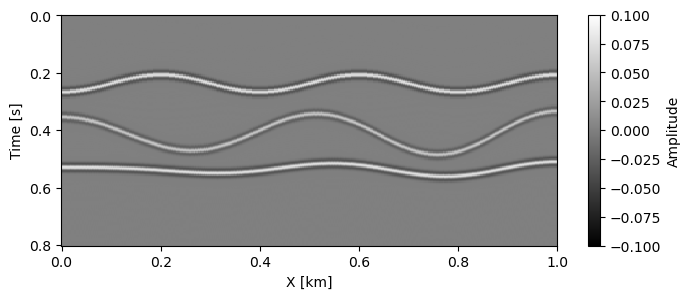

In [ ]:
# compute reflectivity and convolve with Ricker wavelet
ai = Vp_time * (310 * Vp_time**.25)
ai2refl = m8r.sfai2refl() | m8r.sfricker2(frequency=30)
seismic = ai2refl.apply(ai)
seismic.attrs['long_name'] = "Amplitude"
seismic.attrs['units'] = None
seismic.plot(
    figsize=(8, 3), 
    cmap='grey', 
    yincrease=False, 
    vmin=-0.1, vmax=0.1
    )

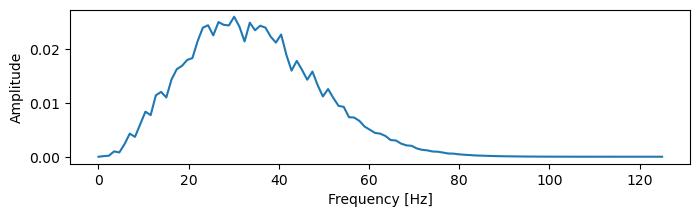

In [14]:
spectra = m8r.spectra(all=True)
seismic_spectra = spectra.apply(seismic)
seismic_spectra
seismic_spectra.plot(figsize=(8, 2))